In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

import torch
import torch.nn as nn
import torch.optim as optim

import optuna

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc,matthews_corrcoef, precision_recall_curve,roc_auc_score



データ読み取り

In [31]:
df=pd.read_csv('learning_data.csv',index_col=0)

X=df.drop(columns='dengue',axis=1).values
y=df['dengue'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1,random_state=42)

#torchテンソルに変換
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)


In [32]:
class DNN_1(nn.Module):
    def __init__(self, input_dim, dropout):
        super(DNN_1, self).__init__()
        self.layer1 = nn.Linear(input_dim, 32)
        self.bn1 = nn.BatchNorm1d(32)
        self.layer2 = nn.Linear(32, 16)
        self.bn2 = nn.BatchNorm1d(16)
        self.layer3 = nn.Linear(16, 8)
        self.bn3 = nn.BatchNorm1d(8)
        self.layer4 = nn.Linear(8, 4)
        self.bn4 = nn.BatchNorm1d(4)
        self.output_layer = nn.Linear(4, 1)

        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        x = torch.relu(self.bn1(self.layer1(x)))  
        x = self.dropout(x)
        
        x = torch.relu(self.bn2(self.layer2(x)))  
        x = self.dropout(x)

        x = torch.relu(self.bn3(self.layer3(x)))  
        x = self.dropout(x)

        x = torch.relu(self.bn4(self.layer4(x))) 
        x = self.dropout(x)

        x = torch.sigmoid(self.output_layer(x)) 
        return x
    

学習データセットの作成

In [33]:
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)

val_dataset = torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=128, shuffle=False)

Optunaの設定

In [34]:
def objective(trial):
    # ハイパーパラメータのサンプリング
    dropout= trial.suggest_float("dropout", 0, 0.5, step=0.05)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  
    weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)   

    # モデルの定義
    model = DNN_1(
        input_dim=X_train_tensor.shape[1],
        dropout=dropout
    ).to(device)

    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Early Stoppingの設定
    patience = 10
    best_val_loss = float('inf')
    patience_counter = 0

    # 訓練ループ
    num_epochs = 100
    for epoch in range(num_epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch).squeeze()
            loss = criterion(outputs, y_batch.squeeze())
            loss.backward()
            optimizer.step()

        # バリデーション評価
        model.eval()
        val_loss = 0
        val_true, val_pred = [], []
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                val_outputs = model(X_val).squeeze()
                val_loss += criterion(val_outputs, y_val.squeeze()).item()
                predictions = (val_outputs >=0.5).float()
                val_true.extend(y_val.cpu().numpy())
                val_pred.extend(predictions.cpu().numpy())

        val_loss /= len(val_loader)

        # Early Stoppingの判定
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

        # Optunaのプルーニング機能
        trial.report(val_loss, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    mcc = matthews_corrcoef(val_true, val_pred)
    print(f"Final MCC: {mcc:.4f}")

    return mcc  


最適化

In [35]:
device_id = 0  
torch.cuda.set_device(device_id)
device = torch.device(f"cuda:{device_id}" if torch.cuda.is_available() else "cpu")

# Optunaの設定
study = optuna.create_study(direction="maximize")  
study.optimize(objective, n_trials=100)

# 結果表示
print("Best Parameters: ", study.best_params)
print("Best Validation F1: ", study.best_value)

[I 2024-12-12 21:01:21,131] A new study created in memory with name: no-name-1d6da8e0-80c7-4689-81b1-4e0ba4ac4de7
/tmp/ipykernel_1419411/1443040819.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_1419411/1443040819.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-12 21:01:34,488] Trial 0 finished with value: 0.3073093301386144 and parameters: {'dropout': 0.45, 'learning_rate': 0.00010168063955670347, 'weight_decay': 0.0022554848941427987}. Best is trial 0 with value: 0.3073093301386144.


Final MCC: 0.3073


/tmp/ipykernel_1419411/1443040819.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_1419411/1443040819.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-12 21:01:48,609] Trial 1 finished with value: 0.0 and parameters: {'dropout': 0.35000000000000003, 'learning_rate': 0.00023165397897743987, 'weight_decay': 0.011217764517790508}. Best is trial 0 with value: 0.3073093301386144.


Final MCC: 0.0000


/tmp/ipykernel_1419411/1443040819.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_1419411/1443040819.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-12 21:01:52,257] Trial 2 finished with value: 0.0 and parameters: {'dropout': 0.5, 'learning_rate': 0.027201862605213283, 'weight_decay': 0.0825781054992377}. Best is trial 0 with value: 0.3073093301386144.


Early stopping at epoch 25
Final MCC: 0.0000


/tmp/ipykernel_1419411/1443040819.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_1419411/1443040819.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-12 21:01:54,332] Trial 3 finished with value: 0.0 and parameters: {'dropout': 0.25, 'learning_rate': 0.005098292619110245, 'weight_decay': 0.031898034047194684}. Best is trial 0 with value: 0.3073093301386144.


Early stopping at epoch 14
Final MCC: 0.0000


/tmp/ipykernel_1419411/1443040819.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_1419411/1443040819.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-12 21:01:57,797] Trial 4 finished with value: 0.0 and parameters: {'dropout': 0.25, 'learning_rate': 0.001111390618320015, 'weight_decay': 0.0905733050356637}. Best is trial 0 with value: 0.3073093301386144.
/tmp/ipykernel_1419411/1443040819.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See 

Early stopping at epoch 24
Final MCC: 0.0000


[I 2024-12-12 21:01:58,106] Trial 6 pruned. 
[I 2024-12-12 21:01:58,250] Trial 7 pruned. 
[I 2024-12-12 21:01:58,401] Trial 8 pruned. 
[I 2024-12-12 21:01:58,540] Trial 9 pruned. 
[I 2024-12-12 21:01:58,708] Trial 10 pruned. 
[I 2024-12-12 21:01:58,870] Trial 11 pruned. 
[I 2024-12-12 21:01:59,031] Trial 12 pruned. 
[I 2024-12-12 21:01:59,221] Trial 13 pruned. 
[I 2024-12-12 21:02:12,690] Trial 14 finished with value: 0.368426949324309 and parameters: {'dropout': 0.30000000000000004, 'learning_rate': 0.00031687835770051394, 'weight_decay': 0.0032316066061143125}. Best is trial 14 with value: 0.368426949324309.
/tmp/ipykernel_1419411/1443040819.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_1419411/1443040819.py:5: FutureWarning: suggest_lo

Early stopping at epoch 96
Final MCC: 0.3684


[I 2024-12-12 21:02:13,034] Trial 16 pruned. 
[I 2024-12-12 21:02:13,208] Trial 17 pruned. 
[I 2024-12-12 21:02:13,411] Trial 18 pruned. 
[I 2024-12-12 21:02:13,583] Trial 19 pruned. 
[I 2024-12-12 21:02:17,669] Trial 20 finished with value: 0.1537350115670227 and parameters: {'dropout': 0.15000000000000002, 'learning_rate': 0.0037557965990024154, 'weight_decay': 0.00015137864307349097}. Best is trial 14 with value: 0.368426949324309.
/tmp/ipykernel_1419411/1443040819.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_1419411/1443040819.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

Early stopping at epoch 28
Final MCC: 0.1537


[I 2024-12-12 21:02:18,010] Trial 22 pruned. 
[I 2024-12-12 21:02:30,500] Trial 23 finished with value: 0.3225307463503984 and parameters: {'dropout': 0.30000000000000004, 'learning_rate': 0.0005750275289853589, 'weight_decay': 7.782279200927984e-05}. Best is trial 14 with value: 0.368426949324309.


Early stopping at epoch 87
Final MCC: 0.3225


/tmp/ipykernel_1419411/1443040819.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_1419411/1443040819.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-12 21:02:43,899] Trial 24 finished with value: 0.2629502940535666 and parameters: {'dropout': 0.30000000000000004, 'learning_rate': 0.0004914560125685322, 'weight_decay': 5.790864852103972e-05}. Best is trial 14 with value: 0.368426949324309.
/tmp/ipykernel_1419411/1443040819.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feat

Early stopping at epoch 94
Final MCC: 0.2630


[I 2024-12-12 21:02:58,089] Trial 26 finished with value: 0.0 and parameters: {'dropout': 0.4, 'learning_rate': 0.0006605022520885754, 'weight_decay': 0.00359208625669485}. Best is trial 14 with value: 0.368426949324309.
/tmp/ipykernel_1419411/1443040819.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_1419411/1443040819.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-12 21:02:58,252] Trial 27 pruned. 


Final MCC: 0.0000


[I 2024-12-12 21:02:58,428] Trial 28 pruned. 
[I 2024-12-12 21:02:58,594] Trial 29 pruned. 
[I 2024-12-12 21:02:58,751] Trial 30 pruned. 
[I 2024-12-12 21:02:58,928] Trial 31 pruned. 
[I 2024-12-12 21:02:59,093] Trial 32 pruned. 
[I 2024-12-12 21:03:12,602] Trial 33 finished with value: 0.1078231143228924 and parameters: {'dropout': 0.35000000000000003, 'learning_rate': 0.0004692843808280634, 'weight_decay': 0.000930039115035641}. Best is trial 14 with value: 0.368426949324309.
/tmp/ipykernel_1419411/1443040819.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_1419411/1443040819.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.

Final MCC: 0.1078


[I 2024-12-12 21:03:12,926] Trial 35 pruned. 
[I 2024-12-12 21:03:13,093] Trial 36 pruned. 
[I 2024-12-12 21:03:13,271] Trial 37 pruned. 
[I 2024-12-12 21:03:13,446] Trial 38 pruned. 
[I 2024-12-12 21:03:13,616] Trial 39 pruned. 
[I 2024-12-12 21:03:13,784] Trial 40 pruned. 
[I 2024-12-12 21:03:13,960] Trial 41 pruned. 
[I 2024-12-12 21:03:14,131] Trial 42 pruned. 
[I 2024-12-12 21:03:14,301] Trial 43 pruned. 
[I 2024-12-12 21:03:14,479] Trial 44 pruned. 
[I 2024-12-12 21:03:14,631] Trial 45 pruned. 
[I 2024-12-12 21:03:14,766] Trial 46 pruned. 
[I 2024-12-12 21:03:14,901] Trial 47 pruned. 
[I 2024-12-12 21:03:15,024] Trial 48 pruned. 
[I 2024-12-12 21:03:28,637] Trial 49 finished with value: 0.33160191126171173 and parameters: {'dropout': 0.25, 'learning_rate': 0.00012996248957965363, 'weight_decay': 0.00014882369245773275}. Best is trial 14 with value: 0.368426949324309.
/tmp/ipykernel_1419411/1443040819.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feat

Final MCC: 0.3316


[I 2024-12-12 21:03:42,586] Trial 51 finished with value: 0.33924192552456345 and parameters: {'dropout': 0.35000000000000003, 'learning_rate': 0.00013982052807270855, 'weight_decay': 0.0001633707030434636}. Best is trial 14 with value: 0.368426949324309.


Final MCC: 0.3392


/tmp/ipykernel_1419411/1443040819.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_1419411/1443040819.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-12 21:03:56,546] Trial 52 finished with value: 0.30882253493342543 and parameters: {'dropout': 0.35000000000000003, 'learning_rate': 0.00010408094960546366, 'weight_decay': 0.00022123638219552103}. Best is trial 14 with value: 0.368426949324309.
/tmp/ipykernel_1419411/1443040819.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This f

Final MCC: 0.3088


[I 2024-12-12 21:03:56,919] Trial 54 pruned. 
[I 2024-12-12 21:03:57,075] Trial 55 pruned. 
[I 2024-12-12 21:03:57,243] Trial 56 pruned. 
[I 2024-12-12 21:03:57,411] Trial 57 pruned. 
[I 2024-12-12 21:03:57,584] Trial 58 pruned. 
[I 2024-12-12 21:03:57,747] Trial 59 pruned. 
[I 2024-12-12 21:03:57,912] Trial 60 pruned. 
[I 2024-12-12 21:03:58,052] Trial 61 pruned. 
[I 2024-12-12 21:03:58,191] Trial 62 pruned. 
[I 2024-12-12 21:03:58,346] Trial 63 pruned. 
[I 2024-12-12 21:03:58,511] Trial 64 pruned. 
[I 2024-12-12 21:03:58,684] Trial 65 pruned. 
[I 2024-12-12 21:03:58,835] Trial 66 pruned. 
[I 2024-12-12 21:03:58,998] Trial 67 pruned. 
[I 2024-12-12 21:03:59,163] Trial 68 pruned. 
[I 2024-12-12 21:03:59,333] Trial 69 pruned. 
[I 2024-12-12 21:04:13,162] Trial 70 finished with value: 0.3444700451315692 and parameters: {'dropout': 0.2, 'learning_rate': 0.00016429350412517973, 'weight_decay': 0.010138111896279807}. Best is trial 14 with value: 0.368426949324309.
/tmp/ipykernel_1419411/144

Final MCC: 0.3445


[I 2024-12-12 21:04:13,500] Trial 72 pruned. 
[I 2024-12-12 21:04:13,665] Trial 73 pruned. 
[I 2024-12-12 21:04:13,859] Trial 74 pruned. 
[I 2024-12-12 21:04:14,037] Trial 75 pruned. 
[I 2024-12-12 21:04:14,235] Trial 76 pruned. 
[I 2024-12-12 21:04:14,411] Trial 77 pruned. 
[I 2024-12-12 21:04:28,621] Trial 78 finished with value: 0.06683528052994064 and parameters: {'dropout': 0.2, 'learning_rate': 0.00023698807096339202, 'weight_decay': 0.0036092191594640976}. Best is trial 14 with value: 0.368426949324309.
/tmp/ipykernel_1419411/1443040819.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_1419411/1443040819.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com

Final MCC: 0.0668


[I 2024-12-12 21:04:28,955] Trial 80 pruned. 
[I 2024-12-12 21:04:29,120] Trial 81 pruned. 
[I 2024-12-12 21:04:29,287] Trial 82 pruned. 
[I 2024-12-12 21:04:29,465] Trial 83 pruned. 
[I 2024-12-12 21:04:29,613] Trial 84 pruned. 
[I 2024-12-12 21:04:29,755] Trial 85 pruned. 
[I 2024-12-12 21:04:29,919] Trial 86 pruned. 
[I 2024-12-12 21:04:30,079] Trial 87 pruned. 
[I 2024-12-12 21:04:30,241] Trial 88 pruned. 
[I 2024-12-12 21:04:30,401] Trial 89 pruned. 
[I 2024-12-12 21:04:30,563] Trial 90 pruned. 
[I 2024-12-12 21:04:30,696] Trial 91 pruned. 
[I 2024-12-12 21:04:30,860] Trial 92 pruned. 
[I 2024-12-12 21:04:31,034] Trial 93 pruned. 
[I 2024-12-12 21:04:31,220] Trial 94 pruned. 
[I 2024-12-12 21:04:31,391] Trial 95 pruned. 
[I 2024-12-12 21:04:31,551] Trial 96 pruned. 
[I 2024-12-12 21:04:31,717] Trial 97 pruned. 
[I 2024-12-12 21:04:31,879] Trial 98 pruned. 
[I 2024-12-12 21:04:32,051] Trial 99 pruned. 


Best Parameters:  {'dropout': 0.30000000000000004, 'learning_rate': 0.00031687835770051394, 'weight_decay': 0.0032316066061143125}
Best Validation F1:  0.368426949324309


In [36]:
best_params = study.best_params

# JSON形式で保存
with open("optim_param/optim_DNN_1_params.json", "w") as f:
    json.dump(best_params, f)

print("Best parameters saved to 'best_params.json'")

Best parameters saved to 'best_params.json'


最適化パラメーターで再学習

Epoch [1/300], Loss: 0.6954
Epoch [1/300], Train Loss: 0.6954, Val Loss: 0.6681
Epoch [2/300], Loss: 0.6928
Epoch [2/300], Train Loss: 0.6928, Val Loss: 0.6599
Epoch [3/300], Loss: 0.6840
Epoch [3/300], Train Loss: 0.6840, Val Loss: 0.6510
Epoch [4/300], Loss: 0.6775
Epoch [4/300], Train Loss: 0.6775, Val Loss: 0.6455
Epoch [5/300], Loss: 0.6632
Epoch [5/300], Train Loss: 0.6632, Val Loss: 0.6394
Epoch [6/300], Loss: 0.6651
Epoch [6/300], Train Loss: 0.6651, Val Loss: 0.6346
Epoch [7/300], Loss: 0.6589
Epoch [7/300], Train Loss: 0.6589, Val Loss: 0.6298
Epoch [8/300], Loss: 0.6536
Epoch [8/300], Train Loss: 0.6536, Val Loss: 0.6270
Epoch [9/300], Loss: 0.6490
Epoch [9/300], Train Loss: 0.6490, Val Loss: 0.6234
Epoch [10/300], Loss: 0.6473
Epoch [10/300], Train Loss: 0.6473, Val Loss: 0.6184
Epoch [11/300], Loss: 0.6446
Epoch [11/300], Train Loss: 0.6446, Val Loss: 0.6174
Epoch [12/300], Loss: 0.6401
Epoch [12/300], Train Loss: 0.6401, Val Loss: 0.6140
Epoch [13/300], Loss: 0.6375
Epoch

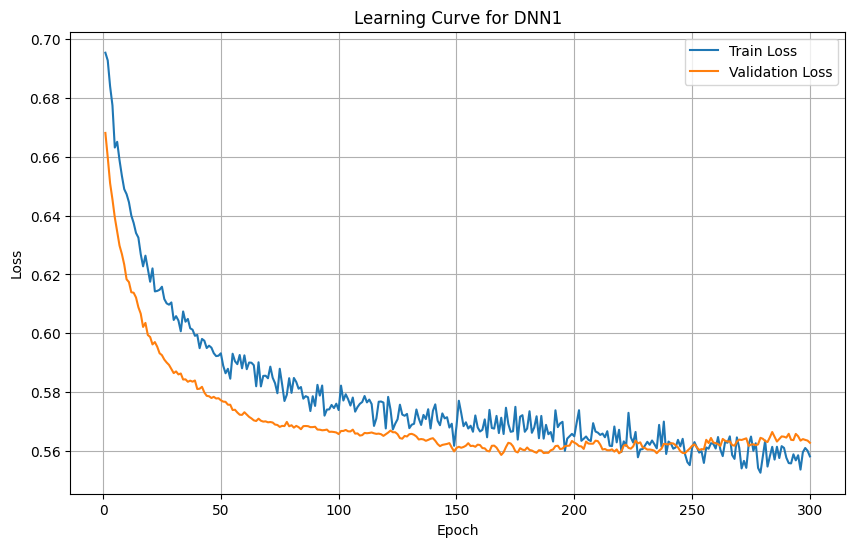

In [49]:
best_params=study.best_params
model = DNN_1(input_dim=X_train_tensor.shape[1],dropout=best_params["dropout"]).to(device)

# 最適化と訓練を実行
optimizer = optim.Adam(model.parameters(), lr=best_params["learning_rate"],weight_decay=best_params["weight_decay"])
criterion = nn.BCELoss()

num_epochs=300
train_losses = []
val_losses = []

model.train()
for epoch in range(num_epochs):
    epoch_train_loss = 0
    epoch_val_loss = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch).squeeze()
        loss = criterion(outputs, y_batch.squeeze())
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}')

    if val_loader is not None:
        model.eval()  
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                val_outputs = model(X_val).squeeze()
                val_loss = criterion(val_outputs, y_val.squeeze())
                epoch_val_loss += val_loss.item()

        avg_val_loss = epoch_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        model.train()  

    if val_loader is not None:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
    else:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
if val_losses:
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve for DNN1')
plt.legend()
plt.grid()
plt.show()

Accuracy: 59.45%
Precision: 0.4867
Recall: 0.9204
F1 Score: 0.6367
Matthews Correlation Coefficient: 0.3399
Specificity: 0.3896


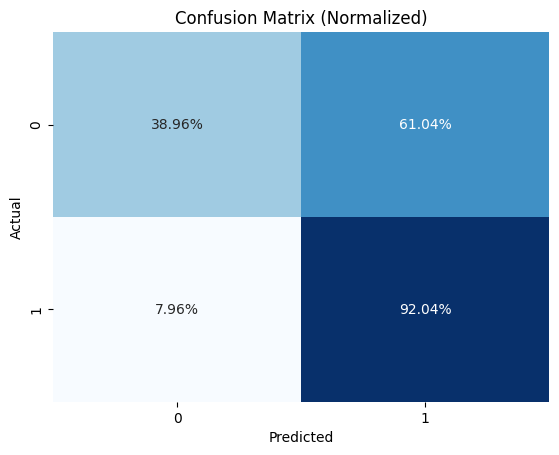

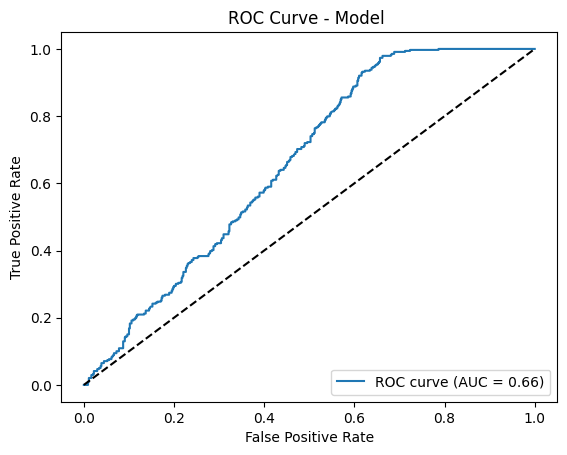

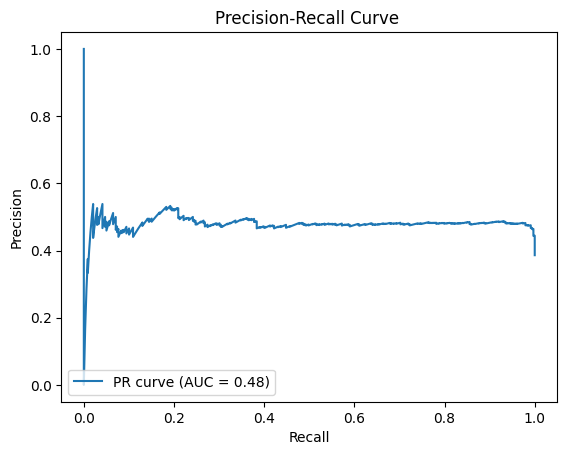

In [50]:
model.eval()
with torch.no_grad():
    X_test_tensor = X_test_tensor.to(device)
    y_test_tensor = y_test_tensor.to(device)

    # 予測と確率
    test_outputs = model(X_test_tensor).squeeze()
    predictions = (test_outputs >=0.5).float()
    y_true = y_test_tensor.cpu().numpy()
    y_pred = predictions.cpu().numpy()
    y_prob = test_outputs.cpu().numpy()

# 評価指標
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    specificity = recall_score(y_true, y_pred, pos_label=0)  
    print(f'Accuracy: {accuracy * 100:.2f}%')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'Matthews Correlation Coefficient: {mcc:.4f}')
    print(f'Specificity: {specificity:.4f}')

    # 混同行列（割合表示）
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    sns.heatmap(cm, annot=True, fmt=".2%", cmap="Blues", cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix (Normalized)")
    plt.show()

    # ROC曲線とAUC
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--') 
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - Model ')
    plt.legend(loc="lower right")
    plt.show()

    # Precision-Recall曲線
    precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_true, y_prob)
    pr_auc = auc(recall_curve, precision_curve)
    plt.plot(recall_curve, precision_curve, label=f'PR curve (AUC = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve ')
    plt.legend(loc="lower left")
    plt.show()    

In [39]:
# モデルと構造を保存
torch.save(model.state_dict(), 'model_params/DNN_1.pth')


In [40]:
from torchsummary import summary
summary(model, input_size=(X_train_tensor.shape[1],))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 32]             960
       BatchNorm1d-2                   [-1, 32]              64
           Dropout-3                   [-1, 32]               0
            Linear-4                   [-1, 16]             528
       BatchNorm1d-5                   [-1, 16]              32
           Dropout-6                   [-1, 16]               0
            Linear-7                    [-1, 8]             136
       BatchNorm1d-8                    [-1, 8]              16
           Dropout-9                    [-1, 8]               0
           Linear-10                    [-1, 4]              36
      BatchNorm1d-11                    [-1, 4]               8
          Dropout-12                    [-1, 4]               0
           Linear-13                    [-1, 1]               5
Total params: 1,785
Trainable params: 1